# Transform Consistency Loss

In [42]:
import pathlib
import tempfile

import torch
import torchvision
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import roma
import tqdm

from Unet2 import UNet
from se3 import se3_log_map, se3_exp_map
# from functorch import jacfwd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [43]:
device

device(type='cuda', index=0)

In [44]:
d_rain= np.load('data_Dynamics_rainy_404.npz')
d_sunny = np.load('data_Dynamics_sunny_404.npz')
nd_rain = np.load('data_noDynamics_rainy_404.npz')
nd_sunny = np.load('data_noDynamics_sunny_404.npz')

In [83]:
# test 
d_rain_dynamics_rgb_test = d_rain['rgbs'][600:650]
d_rain_dynamics_depth_test = d_rain['depths'][600:650]
d_rain_dynamics_transforms_test = d_rain['transforms'][600:650]

d_sunny_dynamics_rgb_test = d_sunny['rgbs'][600:650]
d_sunny_dynamics_depth_test = d_sunny['depths'][600:650]
d_sunny_dynamics_transforms_test = d_sunny['transforms'][600:650]

d_rain_noDynamics_rgb_test = nd_rain['rgbs'][400:450]
d_rain_noDynamics_depth_test = nd_rain['depths'][400:450]
d_rain_noDynamics_transforms_test = nd_rain['transforms'][400:450]

d_sunny_noDynamics_rgb_test = nd_sunny['rgbs'][600:650]
d_sunny_noDynamics_depth_test = nd_sunny['depths'][600:650]
d_sunny_noDynamics_transforms_test = nd_sunny['transforms'][600:650]

# rgb_test =np.concatenate((d_rain['rgbs'][350:400], d_sunny['rgbs'][350:400], nd_rain['rgbs'][350:400], nd_sunny['rgbs'][:250]), axis=0)
# depth_test =np.concatenate((d_rain['depths'][:350], d_sunny['depths'][:350], nd_rain['depths'][:350], nd_sunny['depths'][:250]), axis=0)
K = d_rain['K']
# transforms_test = np.concatenate((d_rain['transforms'][:350], d_sunny['transforms'][:350], nd_rain['transforms'][:350], nd_sunny['transforms'][:250]), axis=0)

In [84]:
# save test 
np.savez_compressed('test_rain_dynamics', rgbs=d_rain_dynamics_rgb_test, depths=d_rain_dynamics_depth_test, K=K, transforms=d_rain_dynamics_transforms_test)
np.savez_compressed('test_sunny_dynamics', rgbs=d_sunny_dynamics_rgb_test, depths=d_sunny_dynamics_depth_test, K=K, transforms=d_sunny_dynamics_transforms_test)
np.savez_compressed('test_rain_noDynamics', rgbs=d_rain_noDynamics_rgb_test, depths=d_rain_noDynamics_depth_test, K=K, transforms=d_rain_noDynamics_transforms_test)
np.savez_compressed('test_sunny_noDynamics', rgbs=d_sunny_noDynamics_rgb_test, depths=d_sunny_noDynamics_depth_test, K=K, transforms=d_sunny_noDynamics_transforms_test)

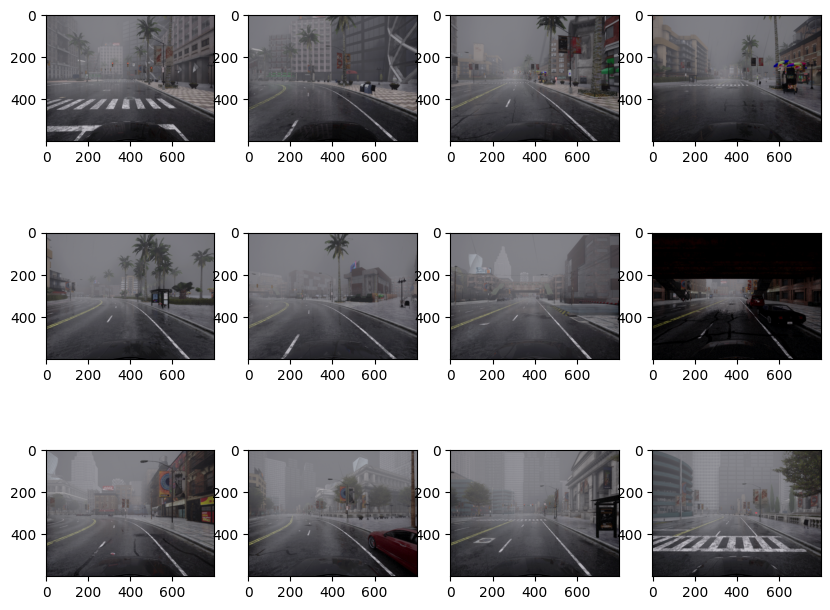

In [29]:
fig,ax = plt.subplots(3,4,figsize=(10,8))
ax[0,0].imshow(  nd_rain['rgbs'][50])
ax[0,1].imshow(  nd_rain['rgbs'][100])
ax[0,0+2].imshow(nd_rain['rgbs'][150])
ax[0,1+2].imshow(nd_rain['rgbs'][200])
ax[1,2-2].imshow(nd_rain['rgbs'][250])##
ax[1,3-2].imshow(nd_rain['rgbs'][300])
ax[1,2].imshow(  nd_rain['rgbs'][350])
ax[1,3].imshow(  nd_rain['rgbs'][400])
ax[2,0].imshow(  nd_rain['rgbs'][450])
ax[2,1].imshow(  nd_rain['rgbs'][500])#
ax[2,0+2].imshow(nd_rain['rgbs'][549])
ax[2,1+2].imshow(nd_rain['rgbs'][600])

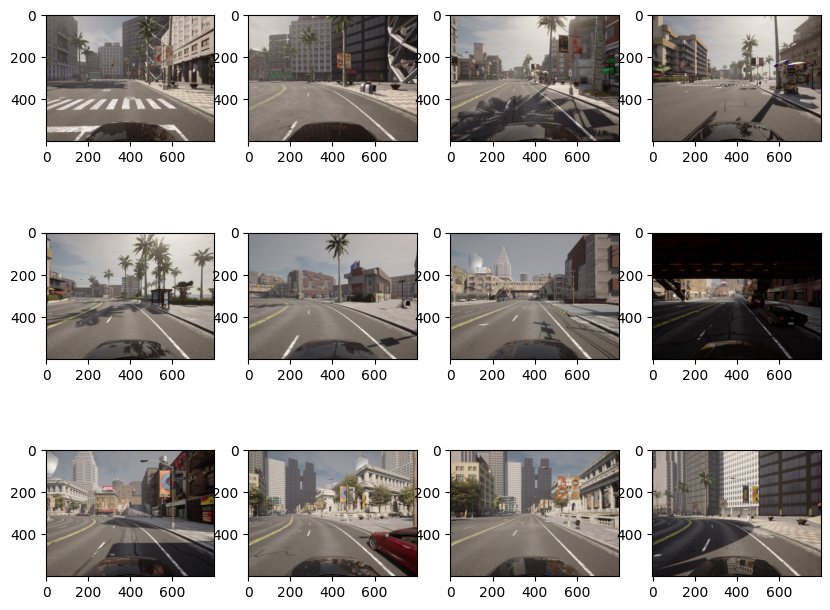

In [29]:
fig,ax = plt.subplots(3,4,figsize=(10,8))
ax[0,0].imshow(  nd_sunny['rgbs'][50])
ax[0,1].imshow(  nd_sunny['rgbs'][100])
ax[0,0+2].imshow(nd_sunny['rgbs'][150])
ax[0,1+2].imshow(nd_sunny['rgbs'][200])
ax[1,2-2].imshow(nd_sunny['rgbs'][250])
ax[1,3-2].imshow(nd_sunny['rgbs'][300])
ax[1,2].imshow(  nd_sunny['rgbs'][350])#
ax[1,3].imshow(  nd_sunny['rgbs'][400])
ax[2,0].imshow(  nd_sunny['rgbs'][450])
ax[2,1].imshow(  nd_sunny['rgbs'][500])
ax[2,0+2].imshow(nd_sunny['rgbs'][520])
ax[2,1+2].imshow(nd_sunny['rgbs'][600])
ax[2,1+2].imshow(nd_sunny['rgbs'][650])#

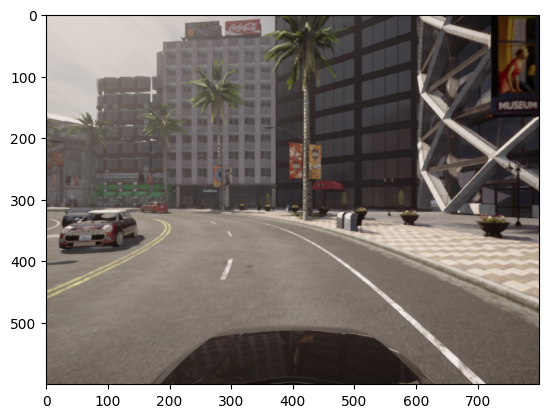

In [33]:
plt.imshow(  d_sunny['rgbs'][110])

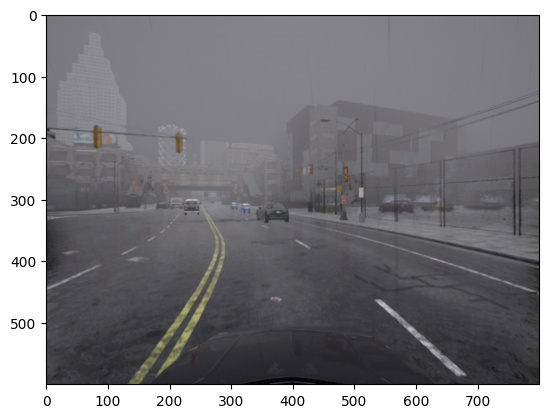

In [37]:
plt.imshow(  d_rain['rgbs'][420])

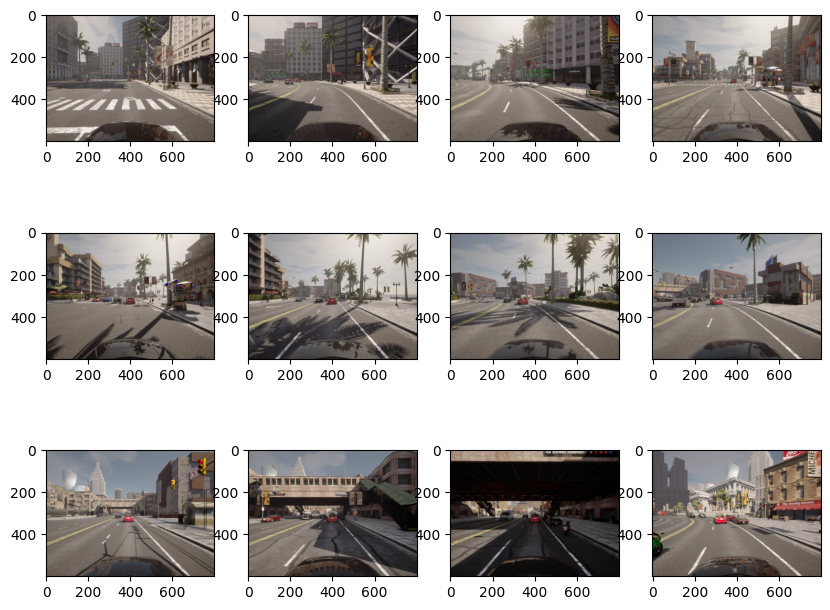

In [31]:
fig,ax = plt.subplots(3,4,figsize=(10,8))
ax[0,0].imshow(  d_sunny['rgbs'][50])
ax[0,1].imshow(  d_sunny['rgbs'][100])
ax[0,0+2].imshow(d_sunny['rgbs'][150])
ax[0,1+2].imshow(d_sunny['rgbs'][200])
ax[1,2-2].imshow(d_sunny['rgbs'][250])
ax[1,3-2].imshow(d_sunny['rgbs'][300])
ax[1,2].imshow(  d_sunny['rgbs'][350])##
ax[1,3].imshow(  d_sunny['rgbs'][400])
ax[2,0].imshow(  d_sunny['rgbs'][450])
ax[2,1].imshow(  d_sunny['rgbs'][500])
ax[2,0+2].imshow(d_sunny['rgbs'][520])
ax[2,1+2].imshow(d_sunny['rgbs'][600])
ax[2,1+2].imshow(d_sunny['rgbs'][650])#


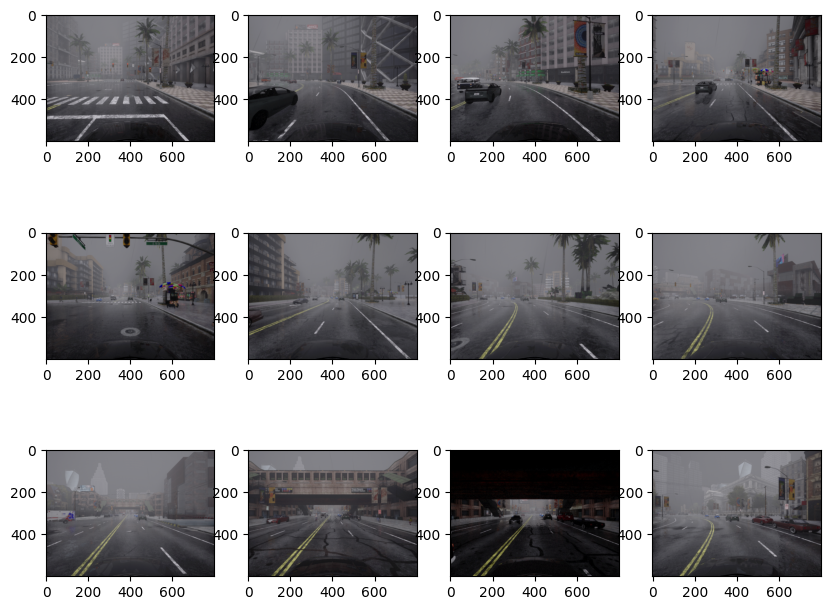

In [30]:
fig,ax = plt.subplots(3,4,figsize=(10,8))
ax[0,0].imshow(  d_rain['rgbs'][50])
ax[0,1].imshow(  d_rain['rgbs'][100])
ax[0,0+2].imshow(d_rain['rgbs'][150])
ax[0,1+2].imshow(d_rain['rgbs'][200])
ax[1,2-2].imshow(d_rain['rgbs'][250])
ax[1,3-2].imshow(d_rain['rgbs'][300])
ax[1,2].imshow(  d_rain['rgbs'][350])#
ax[1,3].imshow(  d_rain['rgbs'][400])
ax[2,0].imshow(  d_rain['rgbs'][450])
ax[2,1].imshow(  d_rain['rgbs'][500])
ax[2,0+2].imshow(d_rain['rgbs'][520])
ax[2,1+2].imshow(d_rain['rgbs'][600])
ax[2,1+2].imshow(d_rain['rgbs'][650])#


In [109]:
# d-rain 400-450, d-summy 400-450
d_rain_dynamics_rgb_test = d_rain['rgbs'][400:450]
d_rain_dynamics_depth_test = d_rain['depths'][400:450]
d_rain_dynamics_transforms_test = d_rain['transforms'][400:450]

d_sunny_dynamics_rgb_test = d_sunny['rgbs'][400:450]
d_sunny_dynamics_depth_test = d_sunny['depths'][400:450]
d_sunny_dynamics_transforms_test = d_sunny['transforms'][400:450]


K = d_rain['K']
# save test 
np.savez_compressed('test_rain_dynamics_410', rgbs=d_rain_dynamics_rgb_test, depths=d_rain_dynamics_depth_test, K=K, transforms=d_rain_dynamics_transforms_test)
np.savez_compressed('test_sunny_dynamics_410', rgbs=d_sunny_dynamics_rgb_test, depths=d_sunny_dynamics_depth_test, K=K, transforms=d_sunny_dynamics_transforms_test)


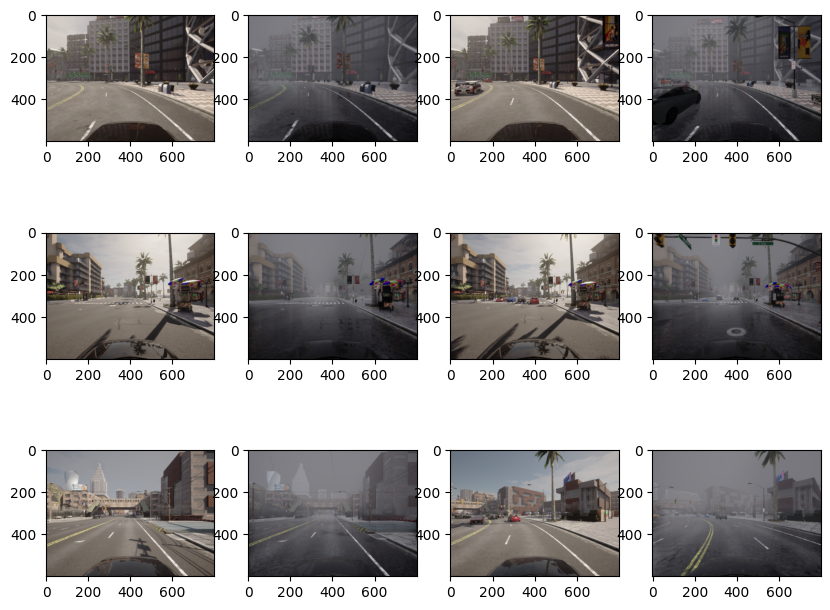

In [108]:
# image for report 
fig,ax = plt.subplots(3,4,figsize=(10,8))
ax[0,0].imshow(  nd_sunny['rgbs'][100])
ax[0,1].imshow(  nd_rain['rgbs'][100])
ax[0,2].imshow(  d_sunny['rgbs'][110])
ax[0,3].imshow(  d_rain['rgbs'][110])
ax[1,0].imshow(  nd_sunny['rgbs'][200])
ax[1,1].imshow(  nd_rain['rgbs'][200])
ax[1,2].imshow(  d_sunny['rgbs'][250])
ax[1,3].imshow(  d_rain['rgbs'][250])
ax[2,0].imshow(  nd_sunny['rgbs'][350])
ax[2,1].imshow(  nd_rain['rgbs'][350])
ax[2,2].imshow(  d_sunny['rgbs'][400])
ax[2,3].imshow(  d_rain['rgbs'][400])

## Extrinsic Representations

We need to work in at least 3 representations of extrinsic matrices for this problem.

1. Rigid body transforms in $SE(3)$ tangent space are represented as a `transform` matrix
2. Rotation matrices in $SO(3)$ tangent space translation vectors are represented as a `pose` tuple
3. The 6 degrees of freedom are represented as a vector of `params`

These are all isomorphisms, and below we define functions for converting between these different representations.

In [4]:
def transform_from_params(params):
    return se3_exp_map(params).mT

In [5]:
def params_from_transform(transform):
    return se3_log_map(transform.mT)

In [6]:
def pose_from_transform(transform):
    return transform[..., :3, :3], transform[..., :3,[3]]

## Data Loader

A good dataloader should read files from the disk and not use too much memory.

Unfortunately, the large dataset that Oli supplied is compressed in `npz` format, and must be uncompressed first before it can be used. Our strategy will be to load the file, then write it out as a temporary `memmap`'d file which can be indexed without needing to read the whole file into memory.

In [38]:
class CarlaTriplesDataset(torch.utils.data.Dataset):
    
    def __init__(self, dataset):
        self.K = torch.from_numpy(dataset['K']).float()
        print(self.K)
        self.K[0] = self.K[0] / 400
        self.K[1] = self.K[1] / 300
        self.rgbs = dataset['rgbs']
        self.depths = dataset['depths']
        self.transforms = dataset['transforms']

    def __len__(self):
        # The size of the dataset should be the number of triples
        # We will assume that each query image uses its adjacent images,
        # so we have N - 2 query images
        return len(self.transforms) - 2

    def __getitem__(self, idx):
        # Our query images in CHW format
        # Note for Yuxin: The images needed to be divided by 255!
        image_0 = torch.from_numpy(self.rgbs[idx+0].copy()).permute(2, 0, 1) / 255
        image_q = torch.from_numpy(self.rgbs[idx+1].copy()).permute(2, 0, 1) / 255
        image_1 = torch.from_numpy(self.rgbs[idx+2].copy()).permute(2, 0, 1) / 255
        # Our depth images i
        depth_0 = torch.from_numpy(self.depths[idx+0].copy() * 1000)
        depth_q = torch.from_numpy(self.depths[idx+1].copy() * 1000)
        depth_1 = torch.from_numpy(self.depths[idx+2].copy() * 1000)

        # Deal with the handness difference between intrinsic and carla extrinsic
        # The mapping is x, y, z -> -z, x, y
        axes = torch.tensor([
            [0, 0,-1, 0],
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 0, 1],
        ]).double()
        
        # Our poses
        extrinsic_0 = torch.from_numpy(self.transforms[idx+0]) @ axes
        extrinsic_q = torch.from_numpy(self.transforms[idx+1]) @ axes
        extrinsic_1 = torch.from_numpy(self.transforms[idx+2]) @ axes
        
        transform_0q = torch.linalg.inv(extrinsic_0) @ extrinsic_q
        transform_1q = torch.linalg.inv(extrinsic_1) @ extrinsic_q
        transform_10 = torch.linalg.inv(extrinsic_1) @ extrinsic_0
        
        #transformation: resize from 600*800 to 120 160
        # resize = torchvision.transforms.Resize((120,160))
        def resize(x):
            # return x
            # return torchvision.transforms.functional.resize(x, (450, 600), antialias=True)
            # # torchvision.transforms.Compose(torchvision.transforms.CenterCrop)
            # return torchvision.transforms.functional.resize(x, (300, 400), antialias=True)
            
            return torchvision.transforms.functional.resize(x, (225, 300), antialias=True)
            # return x[..., 0:200, 50:350]
            # return  x[..., 0:200, 50:350]
        
        return (
            self.K.unsqueeze(0),
            resize(image_q),
            resize(image_0),
            resize(image_1),
            resize(depth_q.unsqueeze(0)).squeeze(),
            resize(depth_0.unsqueeze(0)).squeeze(),
            resize(depth_1.unsqueeze(0)).squeeze(),
            transform_0q.float(),
            transform_1q.float(),
            transform_10.float(),
        )
        # return self.K.unsqueeze(0),image_q,image_0,image_1,depth_q,depth_0,depth_1,pose_q0, pose_q1, pose_01
        # return self.K.unsqueeze(0), torchvision.transforms.functional.resize(image_q,(60,120)), torchvision.transforms.functional.resize(image_0,(60,120)), torchvision.transforms.functional.resize(image_1,(60,120)), torchvision.transforms.functional.resize(depth_q,(60,120)), torchvision.transforms.functional.resize(depth_0,(60,120)), torchvision.transforms.functional.resize(depth_1,(60,120)), pose_q0, pose_q1, pose_01

## Perspective Geometry

In [8]:
def apply_transform(points, transform):
    """
    Project points to camera reference frame
    """
    R, t = transform[..., :3, :3], transform[..., :3, [3]]
    return R @ points + t

In [9]:
def perspective(points, epsilon=1e-8):
    """
    Perspective division
    """
    return points[..., :-1, :] / (points[..., [-1], :] + epsilon)

In [10]:
def project(points, K, height, width):
    """
    Project 3D points into a 2D image with intrinsic matrix K
    """
    coords = K @ points
    coords = perspective(coords)
    coords = coords.view(-1, height, width, 2)
    coords = (coords - 0.5) * 2
    return coords

In [11]:
def backproject(depth, K):
    """
    Backproject a depth map into 3D space with normalized intrinsic matrix K.
    The depth map should be normalized between (min_depth, max_depth).
    """
    height, width = depth.shape[-2:]
    size = height * width
    y = torch.linspace(0, 1, height, device=depth.device, dtype=depth.dtype)
    x = torch.linspace(0, 1, width,  device=depth.device, dtype=depth.dtype)
    u, v = torch.meshgrid(x, y, indexing='xy')
    ones = torch.ones(size, device=depth.device)
    points = torch.column_stack([u.ravel(), v.ravel(), ones]).view(-1, size, 3, 1)
    points = torch.linalg.inv(K) @ points
    return points * depth.view(-1, size, 1, 1)

In [12]:
def pix_coords(height, width, device):
    """
    Create a grid of camera pixels in normalized device coordinates
    """
    size = height * width
    y = torch.linspace(-1, 1, height, device=device)
    x = torch.linspace(-1, 1, width, device=device)
    u, v = torch.meshgrid(x, y, indexing='xy')
    ones = torch.ones(size, device=device)
    return torch.column_stack([u.ravel(), v.ravel(), ones]).view(-1, size, 3, 1)

In [13]:
def warp(homography, image, padding_mode="border"):
    """
    Warp an image using homography
    """
    height, width = image.shape[-2:]
    coords = pix_coords(height, width, device=device)
    warped = project(homography @ coords, height, width)
    warped = F.grid_sample(image, warped, padding_mode=padding_mode, align_corners=False)
    return warped

In [14]:
def grid_sample(image, flow):
    """
    Hacky implementation of torch.nn.functional.grid_sample,
    created so that the derivative can be computed with jacfwd.
    """
    N, C, IH, IW = image.shape
    _, H, W, _ = flow.shape

    ix = flow[..., 0]
    iy = flow[..., 1]

    ix = ((ix + 1) / 2) * (IW-1);
    iy = ((iy + 1) / 2) * (IH-1);
    
    with torch.no_grad():
        ix_nw = torch.floor(ix);
        iy_nw = torch.floor(iy);
        ix_ne = ix_nw + 1;
        iy_ne = iy_nw;
        ix_sw = ix_nw;
        iy_sw = iy_nw + 1;
        ix_se = ix_nw + 1;
        iy_se = iy_nw + 1;

    nw = (ix_se - ix)    * (iy_se - iy)
    ne = (ix    - ix_sw) * (iy_sw - iy)
    sw = (ix_ne - ix)    * (iy    - iy_ne)
    se = (ix    - ix_nw) * (iy    - iy_nw)

    with torch.no_grad():
        ix_nw = torch.clamp(ix_nw, 0, IW-1)
        iy_nw = torch.clamp(iy_nw, 0, IH-1)
        ix_ne = torch.clamp(ix_ne, 0, IW-1)
        iy_ne = torch.clamp(iy_ne, 0, IH-1)
        ix_sw = torch.clamp(ix_sw, 0, IW-1)
        iy_sw = torch.clamp(iy_sw, 0, IH-1)
        ix_se = torch.clamp(ix_se, 0, IW-1)
        iy_se = torch.clamp(iy_se, 0, IH-1)

    image = image.view(N, C, IH * IW)

    nw_val = torch.gather(image, 2, (iy_nw * IW + ix_nw).long().view(N, 1, H * W).repeat(1, C, 1))
    ne_val = torch.gather(image, 2, (iy_ne * IW + ix_ne).long().view(N, 1, H * W).repeat(1, C, 1))
    sw_val = torch.gather(image, 2, (iy_sw * IW + ix_sw).long().view(N, 1, H * W).repeat(1, C, 1))
    se_val = torch.gather(image, 2, (iy_se * IW + ix_se).long().view(N, 1, H * W).repeat(1, C, 1))

    return (
        nw_val.view(N, C, H, W) * nw.view(N, 1, H, W) +    
        ne_val.view(N, C, H, W) * ne.view(N, 1, H, W) +       
        sw_val.view(N, C, H, W) * sw.view(N, 1, H, W) +
        se_val.view(N, C, H, W) * se.view(N, 1, H, W)
    )

In [103]:
def resample(depth, K, transform, target):
    """
    Backproject a depth map with K and transform it into a new reference frame T.
    Sample colors from the target image.
    """
    print("depth.shape", depth.shape)
    print("K.shape", K.shape)
    print("transform.shape", transform.shape)
    print("target.shape", target.shape)
    points_3d = backproject(depth, K)
    print("point3d.shape", points_3d.shape)
    points_3d = apply_transform(points_3d, transform)
    points_2d = project(points_3d, K, depth.shape[-2], depth.shape[-1])
    return grid_sample(target, points_2d)

## Gauss-Newton

In [16]:
class GaussNewtonImageOptimizer(torch.nn.Module):
    
    def __init__(self, K, image, depth):
        super().__init__()
        self.K = K
        self.image = image
        self.depth = depth

        self.residuals_grad = torch.func.jacfwd(self.residuals)
        # self.residuals_grad = jacfwd(self.residuals)
        
    def residuals(self, params, target):
        transform = transform_from_params(params).unsqueeze(1)
        resampled = resample(self.depth, self.K, transform, target)
        residuals = self.image - resampled
        # TODO: Set window size somewhere
        residuals = residuals[..., 0:200, 50:350]
        # residuals = residuals[..., 0:400, 100:700]
        # residuals = residuals[..., 0:300, 100:500]
        return residuals.ravel()

    def update_step(self, params, target):
        r = self.residuals(params, target)
        J = self.residuals_grad(params, target).squeeze()
        H = J.mT @ J + 1e-6 * torch.eye(6, device=J.device)
        return torch.linalg.lstsq(H, J.mT @ -r).solution
    
    def solve(self, params, target, iterations):
        output = params.unsqueeze(0)
        for i in range(iterations):
            update = self.update_step(output.detach(), target).unsqueeze(0)
            output = params_from_transform(
                transform_from_params(output) @
                transform_from_params(update)
            )
        return output

    def forward(self, batch, target, iterations=30):
        # TODO: Try to use VMap for batching
        output = batch.clone()
        for i, params in enumerate(batch):
            output[i] = self.solve(params, target, iterations)
        return output

In [37]:
class GaussNewtonFeatureOptimizer(torch.nn.Module):
    
    def __init__(self, K, features, saliency, depth):
        super().__init__()
        self.K = K
        self.features = features
        self.saliency = saliency
        self.depth = depth
        self.residuals_grad = torch.func.jacfwd(self.residuals)
        # self.residuals_grad = jacfwd(self.residuals)

    def residuals(self, params, features, saliency):
        transform = transform_from_params(params).unsqueeze(1)
        resampled = resample(self.depth, self.K, transform, features)
        # TODO: Saliency
        residuals = self.saliency * saliency * (self.features - resampled)
        # residuals = self.features - resampled
        # residuals = residuals[...,0:250, 50:350]
        residuals = residuals[...,0:190,40:260]
        # residuals = residuals[..., 0:400, 100:500]
        return residuals.ravel()

    def update_step(self, params, features, saliency):
        r = self.residuals(params, features, saliency)
        J = self.residuals_grad(params, features, saliency).squeeze()
        H = J.mT @ J + 1e-6 * torch.eye(6, device=J.device)
        return torch.linalg.lstsq(H, J.mT @ -r).solution
    
    def solve(self, params, features, saliency, iterations):
        output = params.unsqueeze(0)
        for i in range(iterations):
            update = self.update_step(output.detach(), features, saliency).unsqueeze(0)
            output = params_from_transform(
                transform_from_params(output) @
                transform_from_params(update)
            )
        return output

    def forward(self, batch, features, saliency, iterations=30):
        # TODO: Try to use VMap for batching
        output = batch.clone()
        for i, params in enumerate(batch):
            output[i] = self.solve(params, features, saliency, iterations)
        return output

## Loss Functions

## Transform Consistency Loss

Looking carefully at the definition of Transform Consistency Loss:

$$
L_{\mathrm{c}}\left(T_{q, r_0}^*, T_{q, r_1}^k\right)=\left\|\log \left(\hat{T}_{r_0, r_1}\left(T_{q, r_1}^k\right)^{-1} T_{q, r_0}^*\right)\right\|_1 .
$$

Transform Consistency Loss depends on taking the logarithm of a SE(3) matrix. However, SE(3) matrices have negative numbers that we need to deal with.

To compute the logairthm, we will use the function `se3_log_map` from PyTorch3D. As PyTorch3D is a pain to install, I have just copied the code into `se3.py`.

In [18]:
def transform_consistency_loss(T_q0, T_q1, T_01):
    T_1q = torch.linalg.inv(T_q1)
    transform_consistency = T_01.to(T_q0.device) @ T_1q @ T_q0
    return torch.linalg.norm(se3_log_map(transform_consistency.mT))

## Transform Accuracy Loss

This is essentially a sanity check using ground truth data that we have available.

$$
L_{\mathrm{a}}\left(T_{r_1, r_0}^k\right)=\left\|\log \left(\hat{T}_{r_0, r_1} T_{r_1, r_0}^k\right)\right\|_1
$$

In [19]:
def transform_accuracy_loss(T_hat, T_inv_est):
    transform_accuracy = T_hat @ T_inv_est.to(T_hat.device)
    return torch.linalg.norm(se3_log_map(transform_accuracy.mT))

## Data Loader

In [39]:
# memmap_test = load_data_as_memmap('data-2023-03-29-test.npz', tempfile.mkdtemp())
test_rain_dynamics = CarlaTriplesDataset(np.load("test_rain_dynamics.npz")) 
# test_rain_dynamics = CarlaTriplesDataset(np.load("test_sunny_dynamics.npz"))

tensor([[400.,   0., 400.],
        [  0., 400., 300.],
        [  0.,   0.,   1.]])


In [40]:
dataloader_rain_dynamics = torch.utils.data.DataLoader(test_rain_dynamics, batch_size=1, shuffle=False)

## Training block

In [21]:
net = UNet(3, 17).to(device)
# net.train()

# net.load_state_dict(torch.load('weights-2023-03-27.pth'))

loss_batch = []
loss_history = []

In [87]:
net.load_state_dict(torch.load("checkpoints/train_4_4.pth"))

<All keys matched successfully>

In [76]:
optimizer = torch.optim.Adam([
    {'params': net.parameters(), 'lr': 1e-4},
    # {'params': damping, 'lr': 5e-4},
])

In [84]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_0q, transform_1q, transform_10 = (
    x.unsqueeze(0).to(device)
    for x in test_rain_dynamics[0])

# K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_0q, transform_1q, transform_10 = (
#     x.unsqueeze(0).to(device)
#     for x in train_rain_dynamics[400])

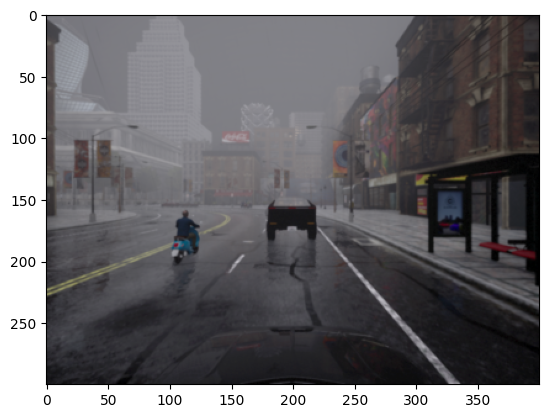

In [107]:
plt.imshow(image_q[0].permute(1,2,0).cpu())
plt.savefig('image_q_test.png')

In [88]:
# load one set of data from dataloader to check 
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
# K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_0q, transform_1q, transform_10 = (
#     x.to(device)
#     for x in next(iter(dataloader_rain_dynamics))
# )

# set inital guess as identity rot-vec. and 0 translation
result_0q = torch.zeros(len(K.double()), 6, device=device) # params_from_transform(transform_q0) # 

with torch.no_grad():
    pyramid_q = net.forward(image_q.to(device))
    pyramid_0 = net.forward(image_0.to(device))
levels = [0, 1, 2, 3]
iterations = [16, 12, 8, 4]
for level in levels:
    features_q, saliency_q = pyramid_q[level]
    features_0, saliency_0 = pyramid_0[level]
        
    # Resample depth maps for pyramid
    size = features_q.shape[-2:]
    depth_0_ = torchvision.transforms.functional.resize(depth_0, size).to(device).unsqueeze(0)

    # Align image_0 to query image
    image_0_optimizer = GaussNewtonFeatureOptimizer(K.double(), features_0.double(), saliency_0.double(), depth_0_.double())

    # residuals_q0 = align_feature_maps(K, features_q, saliency_q, features_0, saliency_0, depth_0_, delta=0.2)
    # result_q0 = gauss_newton_batch(result_q0, residuals_q0, iterations=iterations[level])
    result_0q = image_0_optimizer.forward(result_0q.double(), features_q.double(), saliency_q.double(), iterations=iterations[level])
    print(result_0q)
    
transform_0q_est = transform_from_params(result_0q.double())

tensor([[0., 0., 0., 0., 0., 0.]], device='cuda:0', dtype=torch.float64)
tensor([[-0.0141, -0.0045, -0.0245,  0.0045,  0.0035, -0.0091]],
       device='cuda:0', dtype=torch.float64)
tensor([[-0.0203, -0.0224,  0.0206,  0.0005,  0.0002, -0.0015]],
       device='cuda:0', dtype=torch.float64)
tensor([[ 0.0343,  0.0174, -0.0655, -0.0002, -0.0002,  0.0006]],
       device='cuda:0', dtype=torch.float64)


In [109]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [110]:
features_0[0, 2].shape

torch.Size([300, 400])

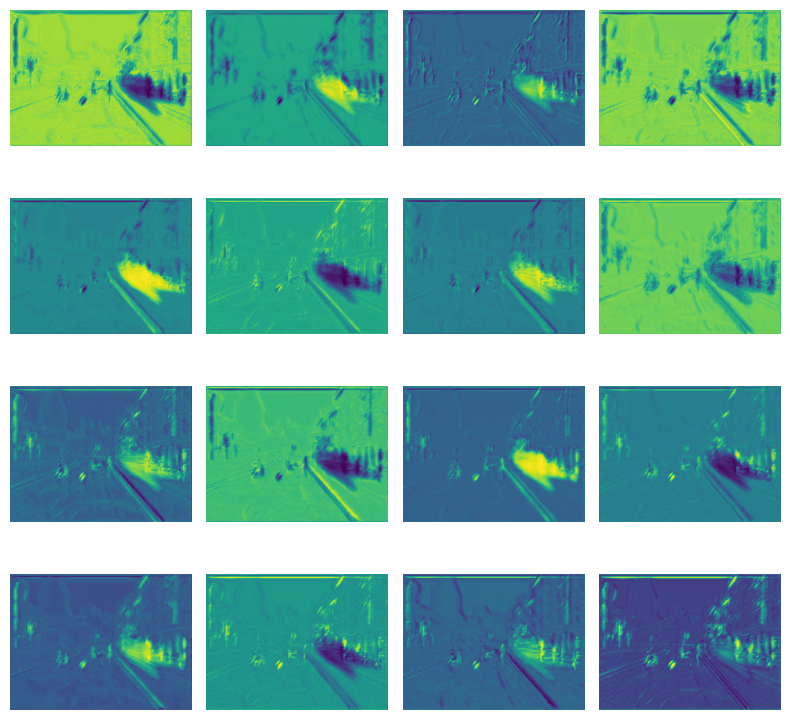

In [89]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axs.ravel()):
    ax.axis('off')
    ax.imshow(features_0[0, i].cpu())
    # cb = axs.imshow(saliency_0[0, 0].squeeze().cpu(), cmap='gray')
    # divider = make_axes_locatable(axs)
    # cax = divider.append_axes("right", size="5%", pad=0.05)
    # plt.colorbar(cb, cax=cax)

plt.tight_layout()
plt.show()
fig.savefig('features_q.png')

In [27]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

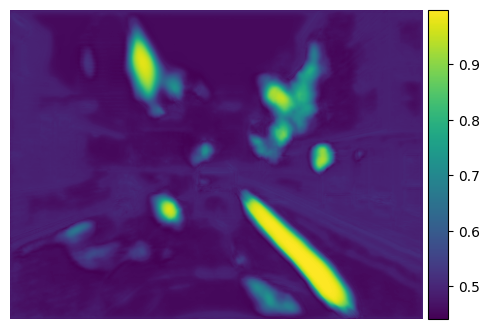

In [113]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.axis('off')
cb = axs.imshow(saliency_0[0, 0].cpu())
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax)
# axs.add_patch(plt.Rectangle((270,230), 10, 10, fill=False, edgecolor='red', lw=3))
plt.tight_layout()
plt.show()
fig.savefig('saliency_q.png')

tensor([[0., 0., 0., 0., 0., 0.]], device='cuda:0', dtype=torch.float64)
tensor([[ 0.0064,  0.0071, -0.0522, -0.0008,  0.0017,  0.0043]],
       device='cuda:0', dtype=torch.float64)
tensor([[ 0.0113,  0.0086, -0.0569,  0.0005,  0.0015,  0.0010]],
       device='cuda:0', dtype=torch.float64)
tensor([[ 0.1775,  0.1471, -0.3727,  0.0015,  0.0015,  0.0006]],
       device='cuda:0', dtype=torch.float64)


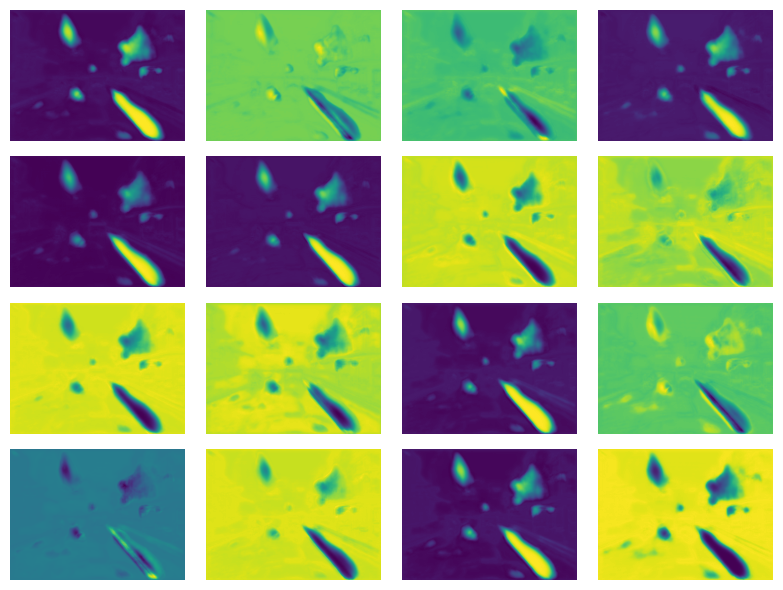

In [91]:
net.load_state_dict(torch.load("weights-2023-03-27.pth"))
# net.load_state_dict(torch.load("checkpoints/train4_10.pth"))
# load one set of data from dataloader to check 
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_0q, transform_1q, transform_10 = (
    x.to(device)
    for x in next(iter(dataloader_rain_dynamics))
)

# set inital guess as identity rot-vec. and 0 translation
result_0q = torch.zeros(len(K.double()), 6, device=device) # params_from_transform(transform_q0) # 

with torch.no_grad():
    pyramid_q = net.forward(image_q.to(device))
    pyramid_0 = net.forward(image_0.to(device))
levels = [0, 1, 2, 3]
iterations = [16, 12, 8, 4]
for level in levels:
    features_q, saliency_q = pyramid_q[level]
    features_0, saliency_0 = pyramid_0[level]
        
    # Resample depth maps for pyramid
    size = features_q.shape[-2:]
    depth_0_ = torchvision.transforms.functional.resize(depth_0, size).to(device).unsqueeze(0)

    # Align image_0 to query image
    image_0_optimizer = GaussNewtonFeatureOptimizer(K.double(), features_0.double(), saliency_0.double(), depth_0_.double())

    # residuals_q0 = align_feature_maps(K, features_q, saliency_q, features_0, saliency_0, depth_0_, delta=0.2)
    # result_q0 = gauss_newton_batch(result_q0, residuals_q0, iterations=iterations[level])
    result_0q = image_0_optimizer.forward(result_0q.double(), features_q.double(), saliency_q.double(), iterations=iterations[level])
    print(result_0q)
    
transform_0q_est = transform_from_params(result_0q.double())
fig, axs = plt.subplots(4, 4, figsize=(8, 6))
for i, ax in enumerate(axs.ravel()):
    ax.axis('off')
    ax.imshow(features_0[0, i].cpu())
    # cb = axs.imshow(saliency_0[0, 0].squeeze().cpu(), cmap='gray')
    # divider = make_axes_locatable(axs)
    # cax = divider.append_axes("right", size="5%", pad=0.05)
    # plt.colorbar(cb, cax=cax)

plt.tight_layout()
plt.show()
fig.savefig('features_q.png')

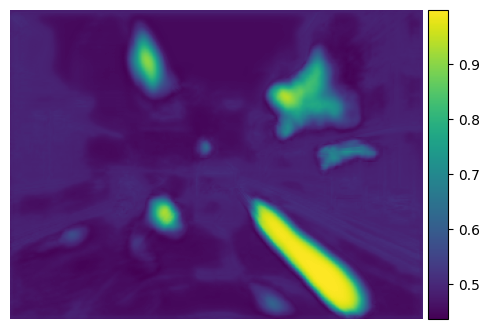

In [92]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.axis('off')
cb = axs.imshow(saliency_q[0, 0].cpu())
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax)
# axs.add_patch(plt.Rectangle((270,230), 10, 10, fill=False, edgecolor='red', lw=3))
plt.tight_layout()
plt.show()
fig.savefig('saliency_q.png')

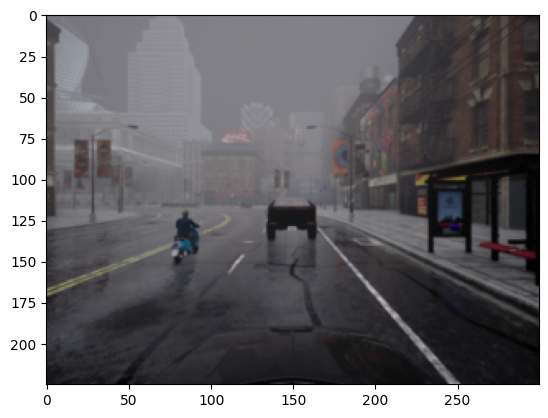

In [48]:
plt.imshow(image_q[0].permute(1,2,0).cpu())

In [53]:
error = params_from_transform(torch.linalg.inv(transform_0q_est.double()) @ transform_0q.double())

print("Translation error: %0.8f" % torch.linalg.norm(error[0, 0:3]))
print("Rotation error:    %0.8f" % torch.linalg.norm(error[0, 3:6]))

Translation error: 0.72307921
Rotation error:    0.00146605


In [94]:
def featuresSaliency(image, net):
    pyramid = net.forward(image)
    features, saliency = pyramid[-1]
    return features, saliency

c:\Users\28340\anaconda3\envs\tcl\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([[0., 0., 0., 0., 0., 0.]], device='cuda:0', dtype=torch.float64)
tensor([[ 0.0064,  0.0071, -0.0522, -0.0008,  0.0017,  0.0043]],
       device='cuda:0', dtype=torch.float64)
tensor([[ 0.0113,  0.0086, -0.0569,  0.0005,  0.0015,  0.0010]],
       device='cuda:0', dtype=torch.float64)
tensor([[ 0.1775,  0.1471, -0.3727,  0.0015,  0.0015,  0.0006]],
       device='cuda:0', dtype=torch.float64)


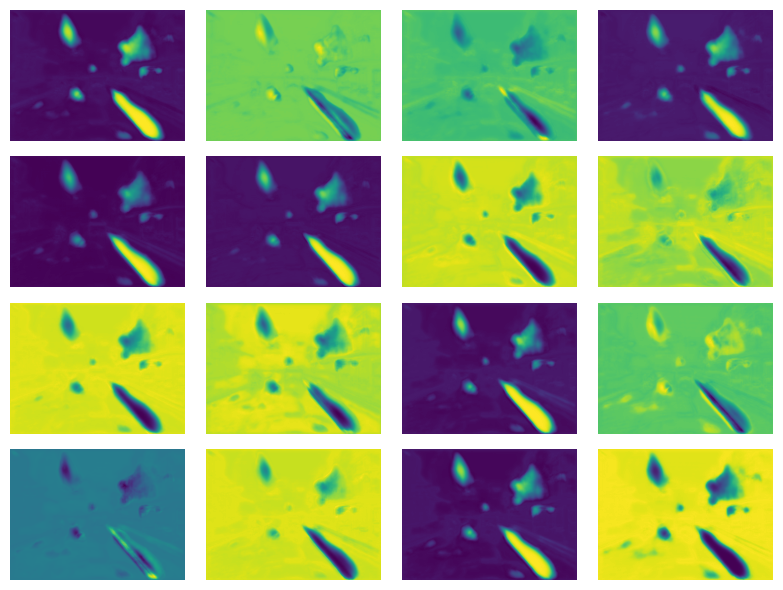

In [85]:
net.load_state_dict(torch.load("weights-2023-03-27.pth"))
# net.load_state_dict(torch.load("checkpoints/train_4.pth"))
# load one set of data from dataloader to check 
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
# K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_0q, transform_1q, transform_10 = (
#     x.to(device)
#     for x in next(iter(dataloader_rain_dynamics))
# )

# set inital guess as identity rot-vec. and 0 translation
result_0q = torch.zeros(len(K.double()), 6, device=device) # params_from_transform(transform_q0) # 

with torch.no_grad():
    pyramid_q = net.forward(image_q.to(device))
    pyramid_0 = net.forward(image_0.to(device))
levels = [0, 1, 2, 3]
iterations = [16, 12, 8, 4]
for level in levels:
    features_q, saliency_q = pyramid_q[level]
    features_0, saliency_0 = pyramid_0[level]
        
    # Resample depth maps for pyramid
    size = features_q.shape[-2:]
    depth_0_ = torchvision.transforms.functional.resize(depth_0, size).to(device).unsqueeze(0)

    # Align image_0 to query image
    image_0_optimizer = GaussNewtonFeatureOptimizer(K.double(), features_0.double(), saliency_0.double(), depth_0_.double())

    # residuals_q0 = align_feature_maps(K, features_q, saliency_q, features_0, saliency_0, depth_0_, delta=0.2)
    # result_q0 = gauss_newton_batch(result_q0, residuals_q0, iterations=iterations[level])
    result_0q = image_0_optimizer.forward(result_0q.double(), features_q.double(), saliency_q.double(), iterations=iterations[level])
    print(result_0q)
    
transform_0q_est = transform_from_params(result_0q.double())
fig, axs = plt.subplots(4, 4, figsize=(8, 6))
for i, ax in enumerate(axs.ravel()):
    ax.axis('off')
    ax.imshow(features_0[0, i].cpu())
    # cb = axs.imshow(saliency_0[0, 0].squeeze().cpu(), cmap='gray')
    # divider = make_axes_locatable(axs)
    # cax = divider.append_axes("right", size="5%", pad=0.05)
    # plt.colorbar(cb, cax=cax)

plt.tight_layout()
plt.show()
fig.savefig('features_q.png')

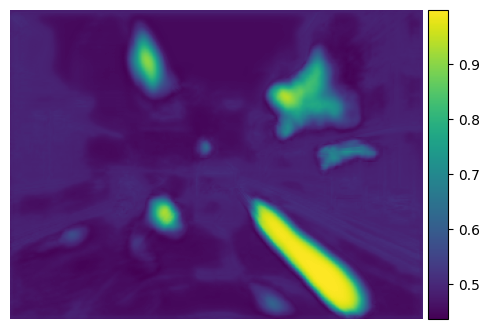

In [86]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.axis('off')
cb = axs.imshow(saliency_q[0, 0].cpu())
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax)
# axs.add_patch(plt.Rectangle((270,230), 10, 10, fill=False, edgecolor='red', lw=3))
plt.tight_layout()
plt.show()
fig.savefig('saliency_q.png')

In [55]:
error = params_from_transform(torch.linalg.inv(transform_0q_est.double()) @ transform_0q.double())

print("Translation error: %0.8f" % torch.linalg.norm(error[0, 0:3]))
print("Rotation error:    %0.8f" % torch.linalg.norm(error[0, 3:6]))

Translation error: 0.43720667
Rotation error:    0.00298936


 Error Function


In [26]:
def errors(transform_0q_est,transform_0q):
    error = params_from_transform(torch.linalg.inv(transform_0q_est.double()) @ transform_0q.double())
    translation_error = torch.linalg.norm(error[0, 0:3])
    rotation_error = torch.linalg.norm(error[0, 3:6])
    
    return translation_error, rotation_error

In [61]:
def test(K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_0q, transform_1q, transform_10):
    result_0q = torch.zeros(len(K.double()), 6, device=device) # params_from_transform(transform_q0) # 

    with torch.no_grad():
        pyramid_q = net.forward(image_q.to(device))
        pyramid_0 = net.forward(image_0.to(device))
    levels = [0, 1, 2, 3]
    iterations = [16, 12, 8, 4]
    for level in levels:
        features_q, saliency_q = pyramid_q[level]
        features_0, saliency_0 = pyramid_0[level]
            
        # Resample depth maps for pyramid
        size = features_q.shape[-2:]
        depth_0_ = torchvision.transforms.functional.resize(depth_0, size).to(device).unsqueeze(0)

        # Align image_0 to query image
        image_0_optimizer = GaussNewtonFeatureOptimizer(K.double(), features_0.double(), saliency_0.double(), depth_0_.double())

        result_0q = image_0_optimizer.forward(result_0q.double(), features_q.double(), saliency_q.double(), iterations=iterations[level])
        # print(result_0q)
        
    transform_0q_est = transform_from_params(result_0q.double())

    rotation_error, translation_error = errors(transform_0q_est, transform_0q)

    return rotation_error, translation_error

In [57]:
def load_data_as_memmap(filename, directory):
    directory = pathlib.Path(directory)
    dataset = np.load(filename)
        
    output = {
        'K': dataset['K'],
        'transforms': dataset['transforms'],
    }
    
    # Send the RGB & depth data to a file on disk to avoid OOM
    for key in ('rgbs', 'depths'):
        data = dataset[key]
        filename = directory / f'{key}.npy'
        fp = np.memmap(filename, dtype='float32', mode='w+', shape=data.shape)
        fp[:] = data[:]
        output[key] = np.memmap(filename, dtype='float32', mode='r', shape=data.shape)
    return output

In [59]:
def test_dataloader(dataloader):
    progress = tqdm.tqdm(dataloader)
    translation_error_list = np.zeros(len(dataloader))
    rotation_error_list = np.zeros(len(dataloader))
    for batch_idx, batch in enumerate(progress):
        K, image_q, image_0, image_1, depth_q, depth_0, depth_1,  transform_0q, transform_1q, transform_10 = (
            x.to(device)
            for x in batch
        )
        rotation_error, translation_error = test(K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_0q, transform_1q, transform_10)
        translation_error_list[batch_idx] = translation_error.item()
        rotation_error_list[batch_idx] = rotation_error.item()
    max_10_translation_error = np.argsort(translation_error_list)[-10:]
    max_10_rotation_error = np.argsort(rotation_error_list)[-10:]
    # max_translation_error_images = [image_q[max_10_translation_error], image_0[max_10_translation_error], image_1[max_10_translation_error]]
    # max_rotation_error_images = [image_q[max_10_rotation_error], image_0[max_10_rotation_error], image_1[max_10_rotation_error]]
    return translation_error_list, rotation_error_list, np.mean(translation_error_list), np.mean(rotation_error_list),max_10_translation_error, max_10_rotation_error
            

In [60]:
dr_translation_error_list, dr_rotation_error_list, dr_mean_translation, dr_mean_rotation,dr_max_10_translation_error, dr_max_10_rotation_error = test_dataloader(dataloader_dr)

  0%|          | 0/398 [00:00<?, ?it/s]


NameError: name 'test' is not defined

In [97]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_0q, transform_1q, transform_10 = dataset_dr[268]

In [95]:
featuresSaliency(image_q,net)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

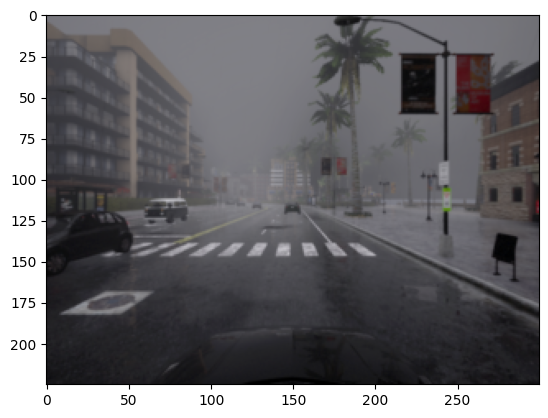

In [82]:
plt.imshow(image_q.permute(1,2,0))

In [44]:
 dr_mean_translation, dr_mean_rotation,dr_max_10_translation_error, dr_max_10_rotation_error

(0.021674109620420705,
 0.34114226287963095,
 array([201, 107,  62, 223,  74, 373, 367, 149, 268, 124], dtype=int64),
 array([296,  42, 367, 149,  62, 184,  20, 268, 107, 124], dtype=int64))

In [50]:
error = params_from_transform(torch.linalg.inv(transform_0q_est.double()) @ transform_0q.double())

print("Translation error: %0.8f" % torch.linalg.norm(error[0, 0:3]))
print("Rotation error:    %0.8f" % torch.linalg.norm(error[0, 3:6]))

Translation error: 0.65253621
Rotation error:    0.00218641


In [99]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_0q, transform_1q, transform_10 = (
    x.to(device)
    for x in next(iter(dataloader_rain_dynamics))
)

In [107]:
transform_0q_est.shape

torch.Size([1, 4, 4])

In [106]:
# reproject using pose_q0_est
reprojected_query_image = resample(depth_0.double().to(device), K.double().to(device), transform_0q_est.double(), image_q.double().to(device))

depth.shape torch.Size([1, 225, 300])
K.shape torch.Size([1, 1, 3, 3])
transform.shape torch.Size([1, 4, 4])
target.shape torch.Size([1, 3, 225, 300])
point3d.shape torch.Size([1, 67500, 3, 1])


In [102]:
image_q.shape, depth_0.shape

(torch.Size([1, 3, 225, 300]), torch.Size([1, 225, 300]))

In [130]:
# reproject using pose_q0
reprojected_query_image_gt = resample(depth_0.double().to(device), K.double().to(device), transform_0q.double(), image_q.double().to(device))

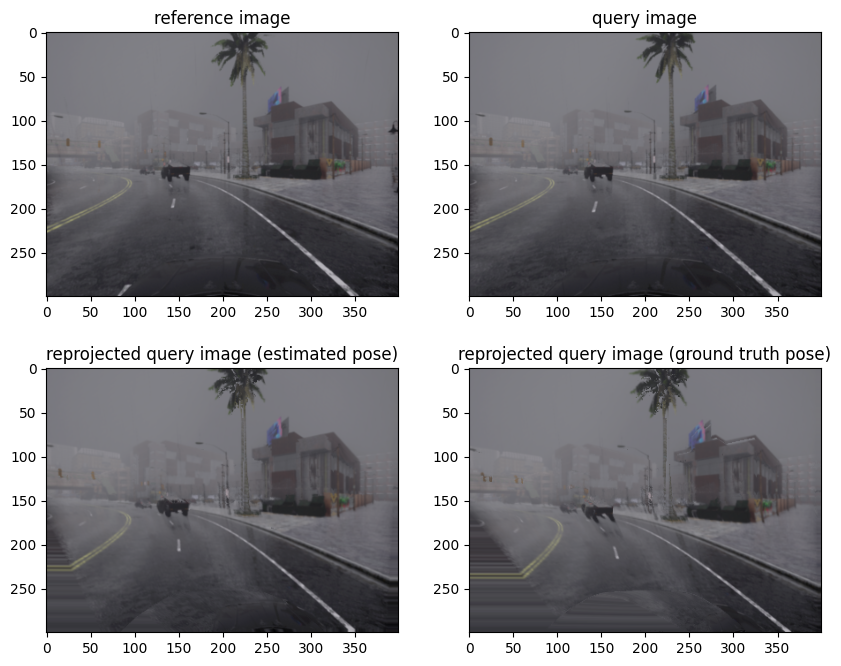

In [135]:
fig,ax =  plt.subplots(2, 2, figsize=(10,8))
ax[0,0].set_title('reference image')
ax[0,1].set_title('query image')
ax[1,0].set_title('reprojected query image (estimated pose)')
ax[1,1].set_title('reprojected query image (ground truth pose)')
ax[0,0].imshow(image_0.cpu().detach().squeeze().permute(1,2,0).numpy())
ax[0,1].imshow(image_q.cpu().detach().squeeze().permute(1,2,0).numpy())
ax[1,0].imshow(reprojected_query_image.cpu().detach().squeeze().permute(1,2,0).numpy())
ax[1,1].imshow(reprojected_query_image_gt.cpu().detach().squeeze().permute(1,2,0).numpy())
fig.savefig('reprojection.png')

In [ ]:
# plt.imshow(reprojected_query_image.cpu().detach().squeeze().permute(1,2,0).numpy())

In [45]:
import matplotlib.pyplot as plt
import numpy as np


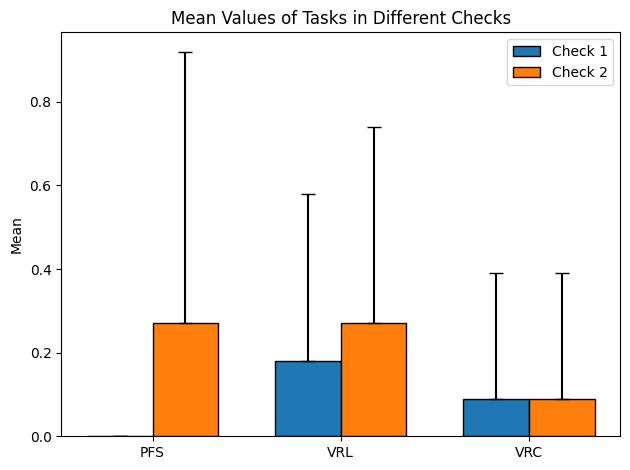

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
means_situation1 = [0, 0.18, 0.09] # check 2
means_situation2 = [0.27, 0.27, 0.09] # check 3
stds_situation1 = [0.0, 0.40, 0.30] #check2
stds_situation2 = [0.65, 0.47, 0.30] #check3

# Number of tasks and situations
num_tasks = 3
num_situations = 2

# Bar width and positions
bar_width = 0.35
task_positions = np.arange(num_tasks)

upper_error_situation1 = stds_situation1
lower_error_situation1 = [0, 0, 0]
upper_error_situation2 = stds_situation2
lower_error_situation2 = [0, 0, 0]

# Combine the custom error bar values into asymmetric error bars
asymmetric_error_situation1 = [lower_error_situation1, upper_error_situation1]
asymmetric_error_situation2 = [lower_error_situation2, upper_error_situation2]

# Create a bar chart with error bars for Situation 1
bars_situation1 = plt.bar(task_positions - bar_width/2, means_situation1, bar_width, yerr=asymmetric_error_situation1, capsize=5, label='Check 1',edgecolor='black')

# Create a bar chart with error bars for Situation 2
bars_situation2 = plt.bar(task_positions + bar_width/2, means_situation2, bar_width, yerr=asymmetric_error_situation2, capsize=5, label='Check 2',edgecolor='black')


# Customize the plot
plt.ylabel('Mean')  # y-axis label
# plt.xlabel('Tasks')  # x-axis label
plt.title('Mean Values of Tasks in Different Checks')  # plot title
plt.xticks(task_positions, ['PFS', 'VRL', 'VRC'])  # x-axis tick labels
plt.legend()  # display legend

# Display the bar chart with error bars
# plt.show()
plt.tight_layout()
plt.savefig('errorRate.png')


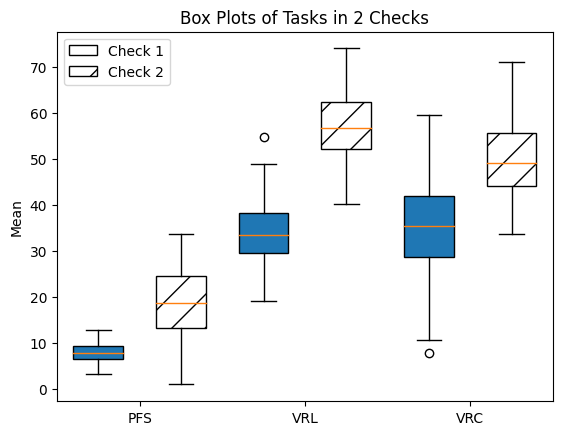

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
data_situation1 = [np.random.normal(mean, std, 100) for mean, std in zip([7.73, 34.45, 34.20], [1.82, 7.12, 9.54])]
data_situation2 = [np.random.normal(mean, std, 100) for mean, std in zip([19.81, 56.91, 50.49], [8.19, 8.53, 8.21])]

# Number of tasks and situations
num_tasks = 3

# Prepare the data for box plot
data = []
for i in range(num_tasks):
    data.append(data_situation1[i])
    data.append(data_situation2[i])

# Set box plot positions and width
box_positions = np.arange(1, num_tasks * 2 + 1, 1)
box_width = 0.6

# Create the box plots
fig, ax = plt.subplots()
bplots = ax.boxplot(data, positions=box_positions, widths=box_width, patch_artist=True)

# Customize the plot
plt.ylabel('Mean')  # y-axis label
plt.xlabel('')  # x-axis label
plt.title('Box Plots of Tasks in 2 Checks')  # plot title
plt.xticks([1.5, 3.5, 5.5], ['PFS', 'VRL', 'VRC'])  # x-axis tick labels

# Add a legend for situation labels
situation1_patch = plt.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black', label='Check 1')
situation2_patch = plt.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black', hatch='/', label='Check 2')
plt.legend(handles=[situation1_patch, situation2_patch])

# Add hatching to the Situation 2 boxes
for box in bplots['boxes'][1::2]:
    box.set_facecolor('white')
    box.set_hatch('/')

# Display the box plot
plt.savefig('boxplot.png')
plt.show()


AttributeError: 'tuple' object has no attribute 'shape'